# Annihilation Notebook

## Initialize the Notebook

The following cell allows external notebooks to be imported as modules.

In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

    
sys.meta_path.append(NotebookFinder())



# from MasterFunctions_Capture import *

from MasterFunctions_Annihilation import *
from MasterFunctions_Graphing import *

print ()
print ('All notebooks imported')

print ('Complete')

importing Jupyter notebook from MasterFunctions_Annihilation.ipynb
importing Jupyter notebook from MasterFunctions_ModelData.ipynb
------ MasterFunctions_ModelData Imported ------
------ MasterFunctions_Annihilation Imported ------
importing Jupyter notebook from MasterFunctions_Graphing.ipynb
------ MasterFunctions_Graphing Loaded ------

All notebooks imported
Complete


----------

# Annihilation Rate

## Annihilation Rate: $C_{ann}$

From Equation 22, $C_{ann}$ is given by:

\begin{equation}
C_{ann} = \langle \sigma_{ann}v \rangle \left[ \frac{G_Nm_X\rho_{\oplus}}{3T_{\oplus}} \right]^{3/2}
\end{equation}

with $\rho_{\oplus} \approx 13 \frac{g}{cm^3}$ and $T_{\oplus} \approx 5700K$


## Thermally Averaged Cross Section: $\langle \sigma_{ann}v \rangle$

here, we define the thermally averaged cross section:

\begin{equation}
\langle \sigma_{ann}v \rangle = (\sigma_{ann}v)_{tree} \langle S_S \rangle 
\end{equation}

where:

\begin{equation}
(\sigma_{ann}v)_{tree} = \frac{\pi \alpha_X^2 [1-m_{A'}^2/m_X^2]^{3/2} }{m_X^2 [1-m_{A'}^2/(2m_X^2)]^2} \end{equation}



## Sommerfeld Enhancement

We note that the Sommerfeld Enhencement $\langle S_s \rangle$ may be calculated explicitly independent of the rest of the Annihilation rate, so we calculate:
\begin{equation}
C_{Ann} = \langle S_s \rangle C_{Ann, 0}
\end{equation}
where $C_{Ann, 0}$ is the annihilation rate without the sommerfeld enhancement. Writing the annihilation rate like this allows us to calculate the Sommerfeld enhancement to arbitrary precision without calculating the entire annihilation rate and then multiply it on when needed.


We see that $\tau \propto \sqrt{1/\langle S_s \rangle}$, so the larger the enhancement, the shorter the equilibium timescale.

The Sommerfeld enhancement is given by:

\begin{equation}
S_S = \frac{\pi}{a} \frac{\sinh(2\pi ac)}{\cosh(2\pi ac) - \cos(2\pi \sqrt{c-(ac)^2}) }
\end{equation}

with its thermal average:

\begin{equation}
\langle S_S \rangle = \int \frac{d^3 v}{(2\pi v_0^2)^{3/2}} \ e^{-\frac{1}{2}v^2/v_0^2} \ S_S 
\end{equation}

where $ a= \frac{v}{2\alpha_X} $, $c=6\alpha_X \frac{m_X}{\pi^2m_{A'}}$, and $v_0 = \sqrt{2T_{\oplus}m_X} $



## Python Definitions

The Python function 
\begin{equation}
\small\text{thermAvgSommerfeld(m_X, m_A, alpha_X)} = \langle S_s \rangle
\end{equation}
encodes the thermally averaged Sommerfeld enhancement.

The function
\begin{equation}
\small\text{CAnn(m_X, m_A, alpha_X, thermAvgSomm = 1)} = \langle S_s \rangle C_{Ann, 0}
\end{equation}
encodes the annihilation rate with the Sommerfeld ehnancement as an explicit value passed into the function. Note that in the function definition, the Sommmerfeld is set to "off" by default.

Annihilation Rate Checks with Flip, error less than 1%. Verified on 7/4/17

### Plot the Thermal Average sommerfeld, and annihilation rates with sommerfeld on and off

The following cell initlizes vectors which store:

1). $\langle S_s \rangle$ calculations

2). $C_{Ann}$ calculations including Sommerfeld enhancements

3). $C_{Ann}$ calculations not including Sommerfeld enhancements


We use a dark matter mass of $1000$ GeV and calculate the Sommerfeld and resulting Annihilation rates for mediator masses between $0.01 - 10$ GeV.

#### Initialize Parameters

In this cell, we define the following values:

1). $m_X$

2). $m_{A, min}$

3). $m_{A, max}$

4). $\text{Num} $

where $m_X$ is the dark matter mass, $m_{A, min}$ and $m_{A, max}$ define the lower and upper value of the mediator mass which span a range between:

\begin{equation}
 10^{m_{A, min}} - 10^{m_{A, max}},
\end{equation}

and $\text{Num} $ defines the number of data points.

In [3]:
m_XTest = 1000.
maLow = -2 # 10^-2
maHigh = 1 #10^1
Num = 500

print ('Complete')

Complete


#### Generate Sommerfeld Vectors

This cell initializes and populates three vectors of length $\text{Num}$ which store:

1). SommVect - $\langle S_s \rangle$

2). CAnnSommVect - $C_{Ann, 0}$

3). CAnnNoSommVect - $C_{Ann}$

which store data given by their names.

In [5]:
maRange = np.logspace(maLow, maHigh, Num, base = 10)
SommVect       = []
CAnnSommVect   = []
CAnnNoSommVect = []

for ma in maRange:
    alpha_XTest = alphaTherm(m_XTest, ma)
    sigmaVTree = photonSigmaVtree(m_XTest, ma, alpha_XTest)
    Somm        = thermAvgSommerfeld(m_XTest, ma, alpha_XTest)
    AnnSomm     = CAnnCalc(m_XTest, sigmaVTree, Somm)
    AnnNoSomm   = CAnnCalc(m_XTest, sigmaVTree)
    
    SommVect.append(Somm)
    CAnnNoSommVect.append(AnnNoSomm)
    CAnnSommVect.append(AnnSomm)

print ('Complete')

Complete


#### Plot the Sommerfeld Enhancement

The following cell plots the Sommerfeld vector "SommVect" populated in the previous cell.

Complete


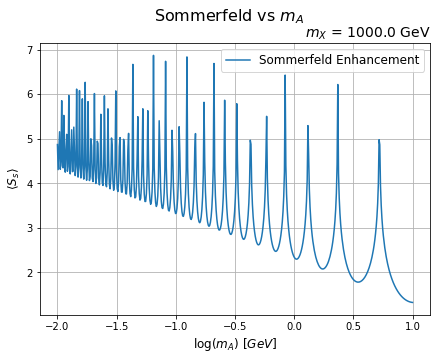

In [6]:
fig0 = plt.figure(figsize = (7,5))
line1, = plt.plot(np.log10(maRange),np.log10(SommVect))
plt.xlabel(r'$\log(m_A)$ $[GeV]$',fontsize = 12)
plt.ylabel(r'$\langle S_s \rangle$', fontsize = 12)
plt.suptitle('Sommerfeld vs $m_A$', fontsize = 16)
plt.title('$m_X$ = {0} GeV'.format(m_XTest),loc = 'right', fontsize = 14)
plt.legend([line1], ['Sommerfeld Enhancement'], fontsize = 12)
plt.grid()

print ('Complete')

#### Plot Annihilation Rate

The following cell plots the Annihilation rate $C_{Ann}$ versus mediator mass with and without Sommerfeld enhancements for comparison. 

Complete


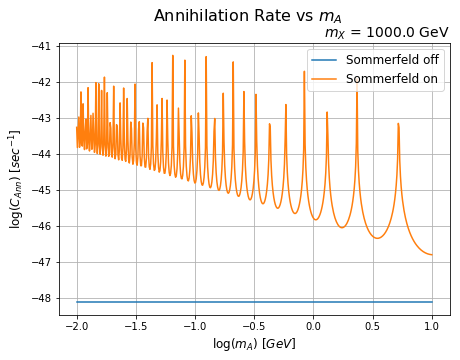

In [7]:
fig1 = plt.figure(figsize = (7,5))
line2, = plt.plot(np.log10(maRange),np.log10(CAnnNoSommVect))
line3, = plt.plot(np.log10(maRange),np.log10(CAnnSommVect))
plt.xlabel(r'$\log(m_A)$ $[GeV]$',fontsize = 12)
plt.ylabel(r'$\log(C_{Ann})$ $[sec^{-1}]$', fontsize = 12)
plt.suptitle('Annihilation Rate vs $m_A$', fontsize = 16)
plt.title('$m_X$ = {0} GeV'.format(m_XTest),loc = 'right', fontsize = 14)
plt.legend([line2,line3],\
           ['Sommerfeld off', 'Sommerfeld on'], fontsize = 12)
plt.grid()

print ('Complete')